# Stations Sensirion
**Purpose:** Analyze the *results*, *random error*, and *systematic error* for the Sensirion sensors used during measurement of air pollution on the Stockholm subway platforms.

### Structure

**Results**

* What is the mean air pollution for each station?
* What is the difference between morning and afternoon?
* Compare during rush hour and off-hour
* How does these values relate to the WHO Guidelines?
* General statistics of measuring time

**Random error**

* Look at distributions
* Look at standard deviations
* Anova

**Systematic error**

* Drift
* How much systematic error would we need to have for an "acceptable value" to be what we observe?


## Setup

In [219]:
################################
# LIBRARIES
################################
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.util import *
from src.frames import *
from src.stats import *
from src.plots import *

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None  # default='warn'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [304]:
# Read Session df, and raw session df
s_df = pd.read_csv('../results/sessions/sensirion.csv')
r_df = pd.read_csv('../results/sessions/sensirion_raw.csv')

# Convert sensor column to string
r_df['Sensor'] = r_df['Sensor'].astype(str)

# Only keep stations from the green line
s_df = s_df[s_df['Station'].isin(get_green_line())]
r_df = r_df[r_df['Station'].isin(get_green_line())]

# Sort by green line
green_line_order = CategoricalDtype(get_green_line(), ordered=True)

s_df['Station Order'] = s_df['Station'].astype(green_line_order)
r_df['Station Order'] = r_df['Station'].astype(green_line_order)

s_df = s_df.sort_values('Station Order')
r_df = r_df.sort_values('Station Order')

# Morning and evening
def morning(x):
    return ((x > '06:00:00') & (x < '09:00:00'))
    
def evening(x):
    return ((x > '16:00:00') & (x < '20:00:00'))
    
s_df['Period'] = s_df['Time'].apply(lambda x: 'Morning rush' if morning(x) else 'Evening rush' if evening(x) else 'Offtime')

# Keep a record of station id's
session_ids = sorted(list(r_df["Session Id"].unique()))

# Choose what param to be analyzed
param = 'PM2.5'
unit = 'µg/m³'

# figure folder
fig_folder = '../results/stations'

## Overview Statistics

### Number of sessions

**Key stats:**

Total sessions: 38

Most sessions: Odenplan, 27

Least sessions: Ängbyplan, 2

In [308]:
x = ['Morning rush', 'test']

x == 'test'

False

In [323]:
### Sessions per station
def total_count(x):
    return len(x)

def morning_rush_count(x):
    return x.value_counts()['Morning rush']

def evening_rush_count(x):
    return x.value_counts()['Evening rush']

def offtime_count(x):
    if 'Offtime' not in x.values:
        return 0
        
    return x.value_counts()['Offtime']

session_count = s_df.groupby('Station').agg({'Period': [total_count, morning_rush_count, evening_rush_count, offtime_count]})

print(f'Total sessions: {len(s_df["Session Id"].unique())}')

session_count['Period'].sort_values(by='total_count', ascending=False)


Total sessions: 38


total_count  morning_rush_count  evening_rush_count  \
Station                                                                 
Odenplan                   27                  12                   7   
St Eriksplan               20                   8                   8   
Fridhemsplan               20                   8                   8   
Kristineberg               20                   8                   8   
Alvik                      20                   8                   8   
Slussen                    18                   9                   5   
Medborgarplatsen           17                   9                   5   
Thorildsplan               17                   6                   7   
T-Centralen                17                   8                   5   
Gamla Stan                 17                   9                   5   
Rådmansgatan               17                   8                   5   
Skanstull                  17                   9                   5   
Gullmarsplan               16                   8                   5   
Hötorget                   16                   7                   5   
Stora mossen               11                   3                   6   
Abrahamsberg               11                   3                   7   
Brommaplan                 11                   3                   7   
Åkeshov                     9                   2                   6   
Islandstorget               4                   2                   2   
Angbyplan                   2                   1                   1   

                  offtime_count  
Station                          
Odenplan                      8  
St Eriksplan                  4  
Fridhemsplan                  4  
Kristineberg                  4  
Alvik                         4  
Slussen                       4  
Medborgarplatsen              3  
Thorildsplan                  4  
T-Centralen                   4  
Gamla Stan                    3  
Rådmansgatan                  4  
Skanstull                     3  
Gullmarsplan                  3  
Hötorget                      4  
Stora mossen                  2  
Abrahamsberg                  1  
Brommaplan                    1  
Åkeshov                       1  
Islandstorget                 0  
Angbyplan                     0

### Measurement time

**Key statistics**

Total unique measuring time: 24h 41m 34s

Total measuring time across sensors: 119h 22m 57s

Station sensor measuring time: 42h 58m 40s 

Unique station sensor measuring time: 7h 55m 24s

In [54]:
def print_time(msg, seconds):
    m, s = divmod(total_seconds, 60)
    h, m = divmod(m, 60)
    
    print(f'{msg}: {h:d}h {m:02d}m {s:02d}s')
    

In [55]:
### Total measuring time
m_df = pd.read_csv('../results/measurement_time.csv')

total_seconds = int(m_df['Seconds'].sum())
print_time('Total sensor time', total_seconds)

m_df.sort_values(by=['Sensor'])

Total sensor time: 119h 22m 57s


Sensor  Seconds
3       1    56602
0       2    83408
4       3    51184
1       4    43440
5       5    33260
6       6    16875
7       A    18212
2       B    58711
8       C    21782
9       D    23331
10      E    22972

**Unique measuring time**

In [56]:
### Unique measuring time
m_df = pd.read_csv('../results/measurement_researcher_time.csv')

total_seconds = int(m_df['Seconds'].sum())
print_time('Total unique measuring time', total_seconds)

m_df.sort_values(by=['Date'])

Total unique measuring time: 24h 41m 34s


Date  Seconds
4   2021-09-22     1777
6   2021-09-23     3955
5   2021-09-24     4356
14  2021-09-27     8558
13  2021-09-28     8904
15  2021-09-29     6071
0   2021-09-30     6917
9   2021-10-01     8042
2   2021-10-04     4751
1   2021-10-05     9168
8   2021-10-06     5188
10  2021-10-07     5620
7   2021-10-08     3107
3   2021-10-11     4165
12  2021-10-12     3956
11  2021-10-13     4359

**Measuring time per station**

In [58]:
station_times = {}

for station, station_grp in r_df.groupby('Station'):
    for session_id, session_grp in station_grp.groupby('Session Id'):
        if station not in station_times:
            station_times[station] = []
            
        station_times[station].append(len(session_grp))

total_times = {s: sum(v) for s, v in station_times.items()}
total_time_df = pd.DataFrame(total_times.items(), columns=["Station", "Seconds"])

total_seconds = int(total_time_df['Seconds'].sum())
print_time('Total station measuring time', total_seconds)

total_time_df.sort_values(by=['Seconds'], ascending=False)

Total station measuring time: 42h 58m 40s


Station  Seconds
11          Odenplan    29848
10  Medborgarplatsen     8868
1              Alvik     8742
4       Fridhemsplan     8493
9       Kristineberg     8258
3         Brommaplan     8254
5         Gamla Stan     7781
13         Skanstull     7646
17       T-Centralen     7557
12      Rådmansgatan     7284
19           Åkeshov     7207
15      St Eriksplan     7088
14           Slussen     6955
7           Hötorget     6809
18      Thorildsplan     6654
6       Gullmarsplan     5930
16      Stora mossen     5378
0       Abrahamsberg     4493
8      Islandstorget      904
2          Angbyplan      571

In [60]:
unique_times = {s: max(v) for s, v in station_times.items()}
unique_time_df = pd.DataFrame(unique_times.items(), columns=["Station", "Seconds"])

total_seconds = int(unique_time_df['Seconds'].sum())
print_time('Total station measuring time', total_seconds)

unique_time_df.sort_values(by=['Seconds'], ascending=False)

Total station measuring time: 7h 55m 24s


Station  Seconds
11          Odenplan     8182
19           Åkeshov     2155
3         Brommaplan     1921
5         Gamla Stan     1470
1              Alvik     1457
16      Stora mossen     1172
12      Rådmansgatan     1156
18      Thorildsplan     1098
17       T-Centralen     1050
13         Skanstull     1020
0       Abrahamsberg     1014
10  Medborgarplatsen      989
6       Gullmarsplan      937
4       Fridhemsplan      912
14           Slussen      867
9       Kristineberg      823
7           Hötorget      812
15      St Eriksplan      755
8      Islandstorget      379
2          Angbyplan      355

## General statistics
Grand mean, median, mode, standard deviation and confidence interval

In [172]:
general_stats = s_df.groupby('Station').agg({param: ['mean', 'median', mode, 'min', 'max', x_range, sample_std, CI95, CV, standard_error]})
general_stats['order index'] = [get_green_line().index(name) for name in general_stats[param].index]

general_stats.sort_values('order index')


PM2.5                                              \
                       mean     median       mode        min        max   
Station                                                                   
Islandstorget      4.846917   3.883000   1.033333   1.033333  10.588333   
Angbyplan          5.159000   5.159000   2.238000   2.238000   8.080000   
Åkeshov            3.846926   2.448000   1.093333   1.093333  10.600000   
Brommaplan         4.336152   2.265000   1.535000   1.535000  11.628333   
Abrahamsberg       4.555303   2.426000   1.005000   1.005000  14.658333   
Stora mossen       4.506848   2.594000   0.870000   0.870000  12.310000   
Alvik              4.524067   2.968000   1.088000   1.088000  13.996667   
Kristineberg       4.765817   3.004000   1.170000   1.170000  13.496667   
Thorildsplan       4.536794   2.640000   1.026000   1.026000  14.470000   
Fridhemsplan      18.884600  18.566667  10.228000  10.228000  33.314000   
St Eriksplan      25.083433  25.514667  16.004000  16.004000  29.460000   
Odenplan          27.442630  28.098000  19.345000  19.345000  32.890000   
Rådmansgatan      29.900804  27.435000  21.256000  21.256000  60.045000   
Hötorget          35.500708  36.015833  25.032000  25.032000  44.035000   
T-Centralen       31.049382  31.975000  19.486000  19.486000  38.472500   
Gamla Stan         8.304176   7.250000   3.895000   3.895000  16.252000   
Slussen           22.368111  21.095000   9.413333   9.413333  36.315000   
Medborgarplatsen  18.011765  18.538000  13.490000  13.490000  24.530000   
Skanstull         14.960402  13.176000   9.071667   9.071667  27.986667   
Gullmarsplan       4.418938   3.729250   0.460000   0.460000  10.778000   

                                                                           \
                    x_range sample_std      CI95        CV standard_error   
Station                                                                     
Islandstorget      9.555000   4.103318  4.021251  0.846583       2.051659   
Angbyplan          5.842000   4.130918  5.725160  0.800721       2.921000   
Åkeshov            9.506667   3.381522  2.209261  0.879019       1.127174   
Brommaplan        10.093333   3.746139  2.213826  0.863932       1.129503   
Abrahamsberg      13.653333   4.396913  2.598409  0.965230       1.325719   
Stora mossen      11.440000   3.935369  2.325654  0.873198       1.186558   
Alvik             12.908667   3.561150  1.560743  0.787157       0.796297   
Kristineberg      12.326667   3.684475  1.614792  0.773105       0.823874   
Thorildsplan      13.444000   3.602473  1.712507  0.794057       0.873728   
Fridhemsplan      23.086000   4.830008  2.116844  0.255764       1.080023   
St Eriksplan      13.456000   3.208468  1.406173  0.127912       0.717435   
Odenplan          13.545000   3.751801  1.415188  0.136714       0.722034   
Rådmansgatan      38.789000   9.686052  4.604457  0.323940       2.349213   
Hötorget          19.003000   5.387087  2.639673  0.151746       1.346772   
T-Centralen       18.986500   4.736791  2.251727  0.152557       1.148841   
Gamla Stan        12.357000   4.217073  2.004669  0.507826       1.022790   
Slussen           26.901667   8.447146  3.902382  0.377642       1.991011   
Medborgarplatsen  11.040000   2.772988  1.318195  0.153954       0.672548   
Skanstull         18.915000   4.697332  2.232970  0.313984       1.139270   
Gullmarsplan      10.318000   2.937116  1.439187  0.664666       0.734279   

                 order index  
                              
Station                       
Islandstorget              0  
Angbyplan                  1  
Åkeshov                    2  
Brommaplan                 3  
Abrahamsberg               4  
Stora mossen               5  
Alvik                      6  
Kristineberg               7  
Thorildsplan               8  
Fridhemsplan               9  
St Eriksplan              10  
Odenplan                  11  
Rådmansgatan              12  
Hötorget                  13

## Distribution

### Box Plot 1

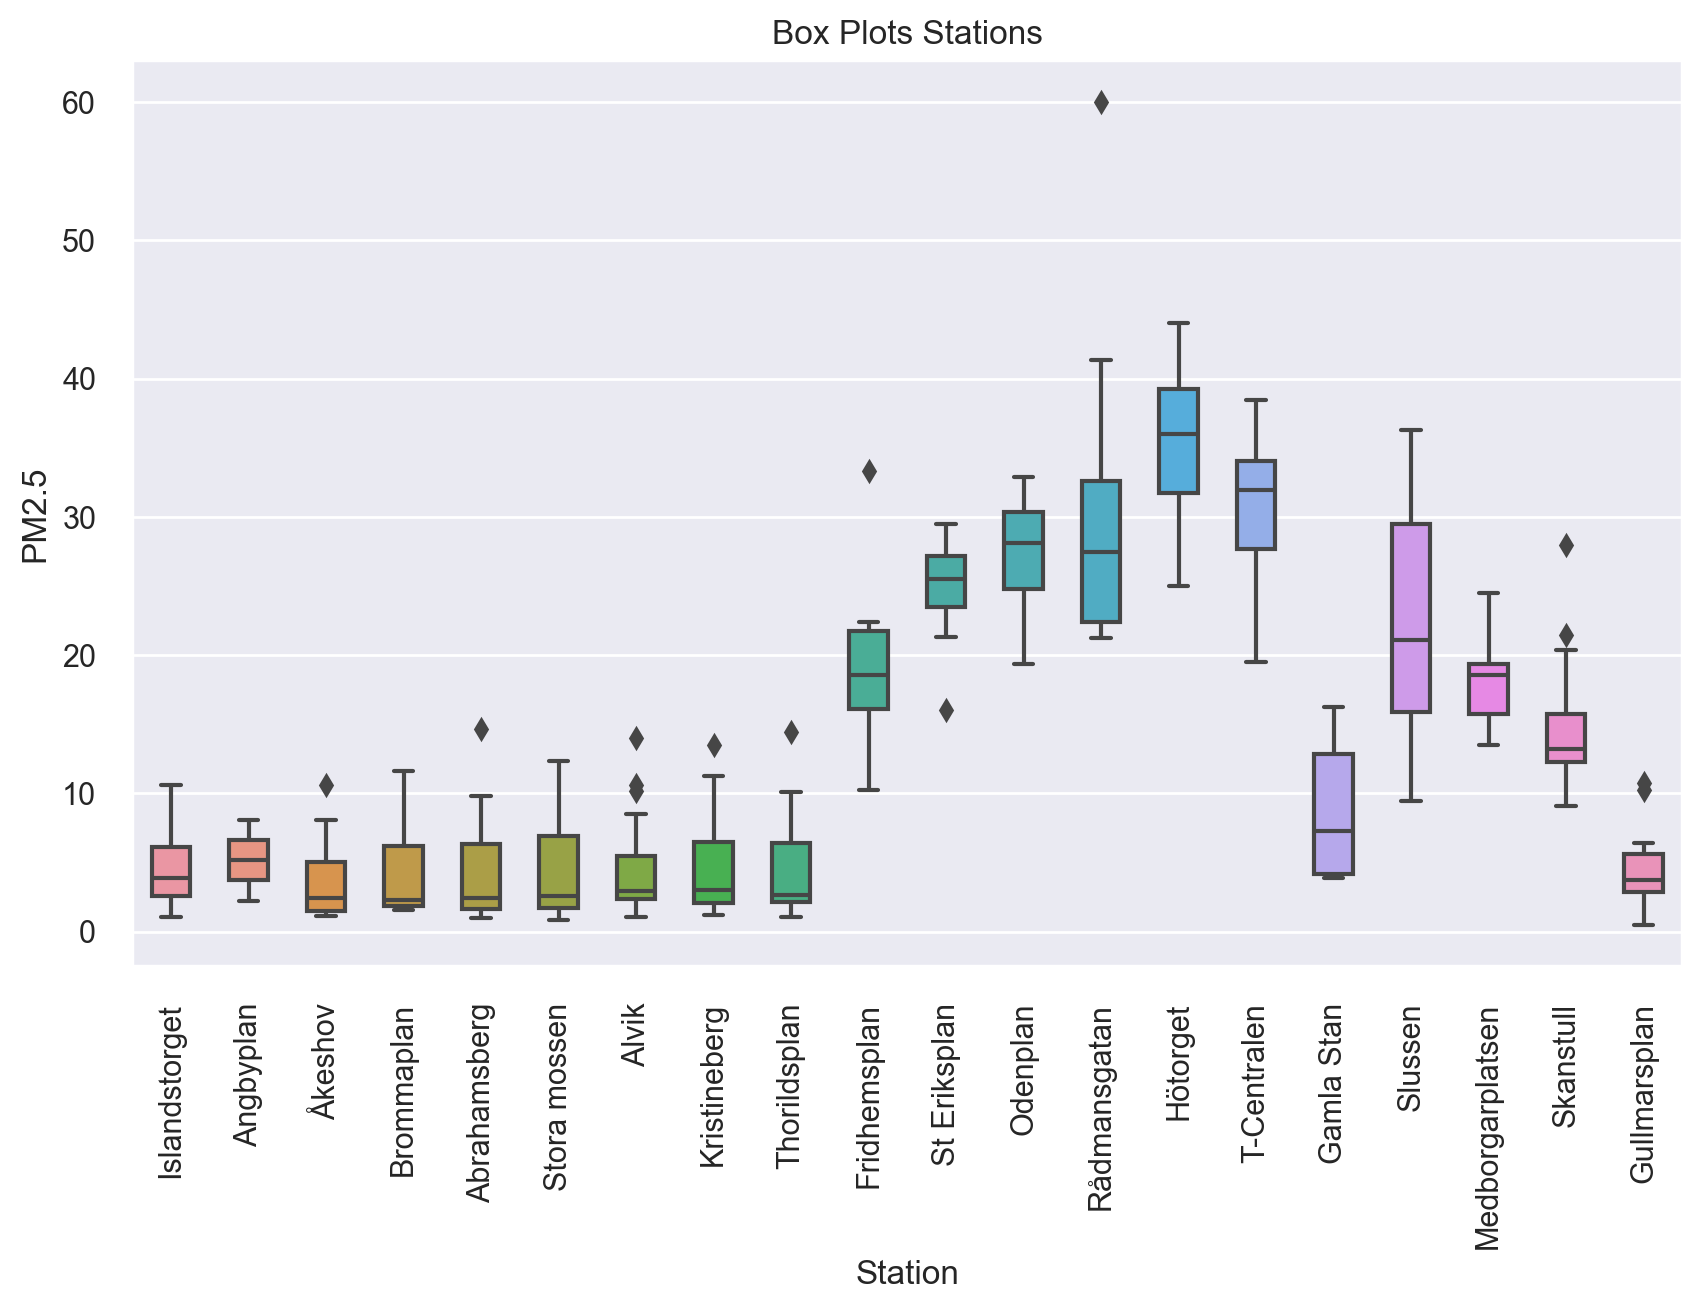

In [85]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Station', y=param, data=s_df, width=0.5, order=get_green_line())
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots({param}).pdf')

plt.show()

### Box plot with lines

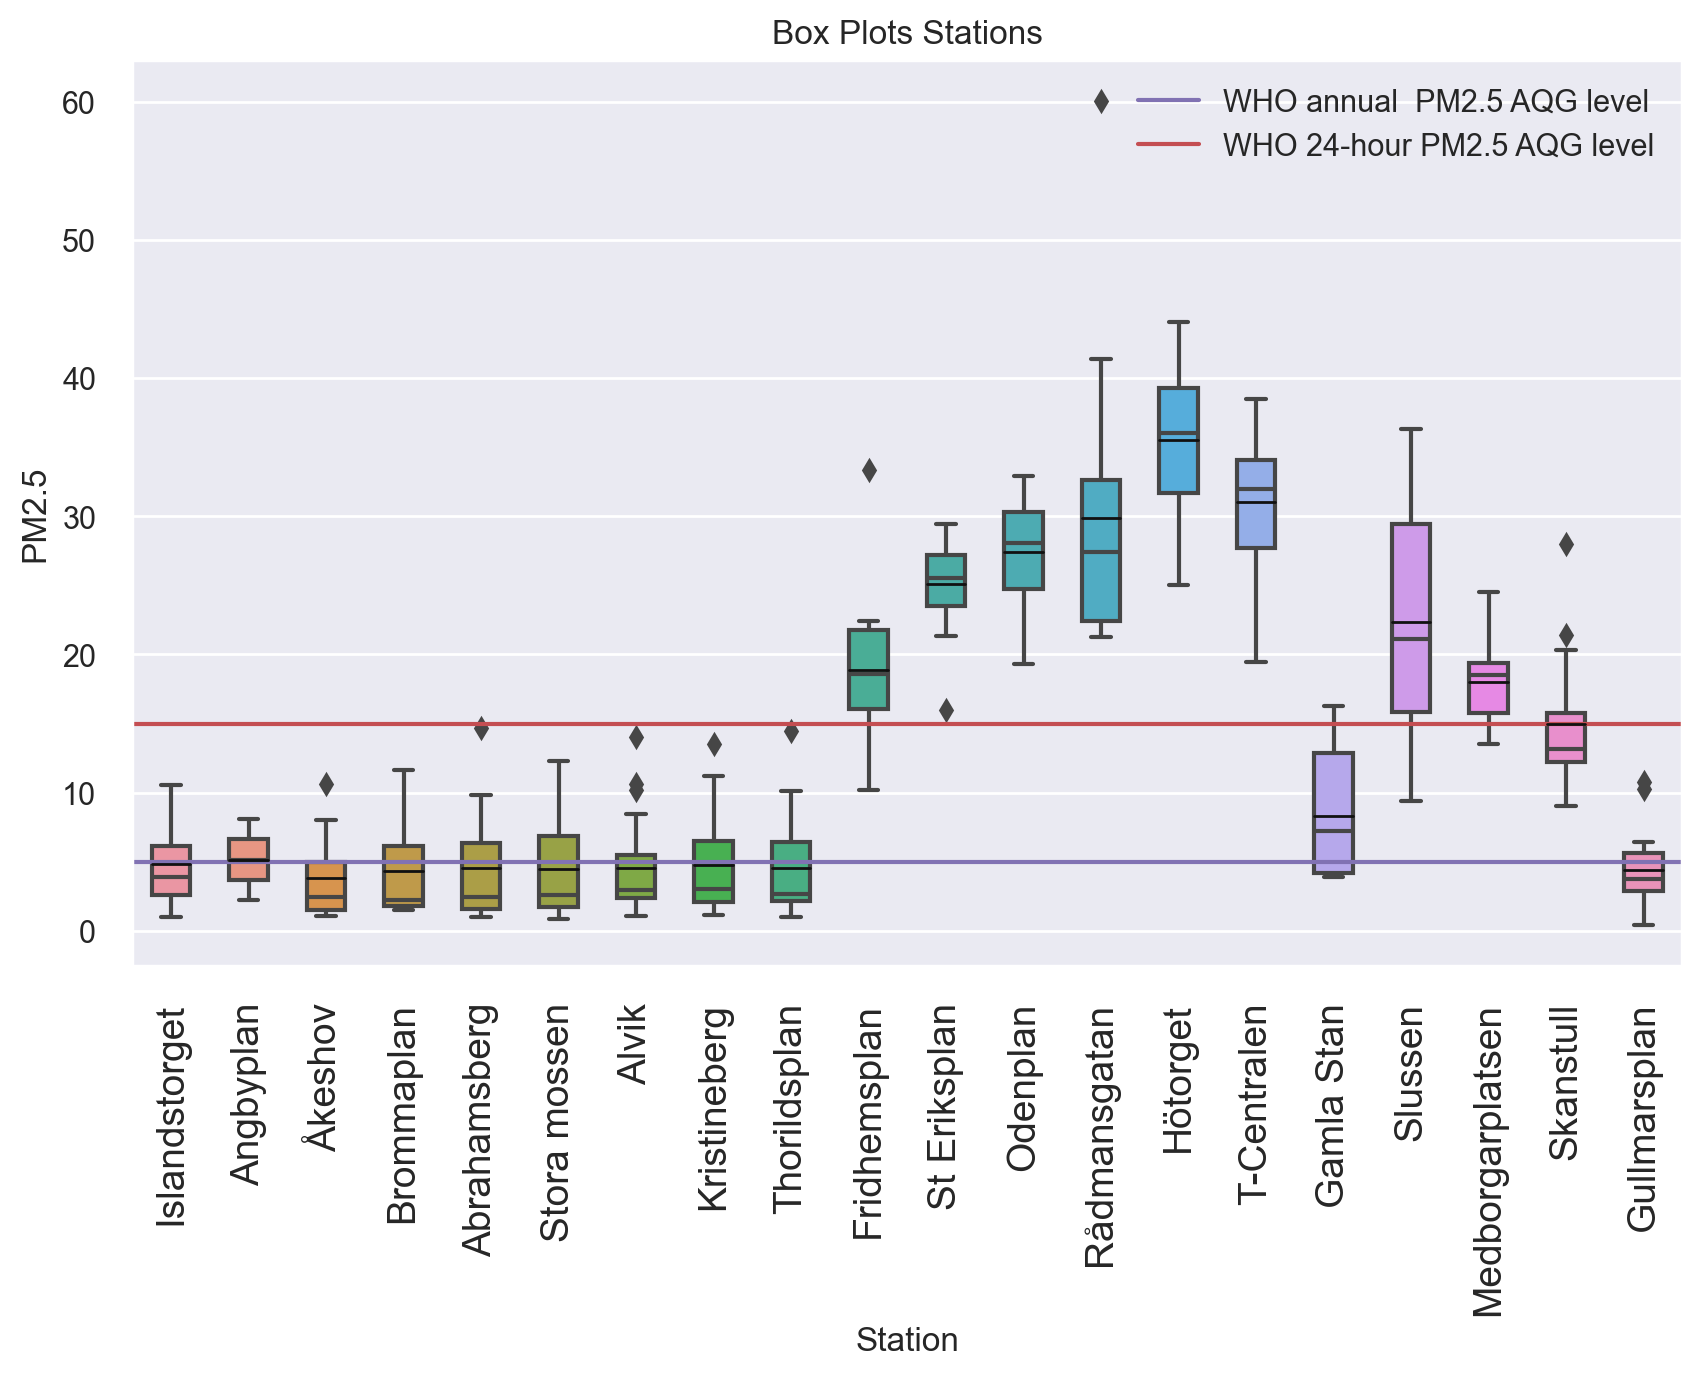

In [205]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(
    x='Station', 
    y=param, 
    data=s_df, 
    width=0.5, 
    order=get_green_line(), 
    showmeans=True, 
    meanline=True, 
    meanprops={'color': '#111', 'ls': '-', 'lw': 1}
)

plt.axhline(5, label='WHO annual  PM2.5 AQG level', c='m')
plt.axhline(15, label='WHO 24-hour PM2.5 AQG level', c='r')

plt.legend()
plt.xticks(rotation=90, fontsize=14)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots_lines({param}).pdf')

plt.show()

**Comments**

Hötorget, T-Centralen, and Rådmansgatan have the highest means.

### Quantiles and outliers

In [140]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
station_quantiles = s_df.groupby('Station').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

station_quantiles[param].sort_values(by='outliers', ascending=False)

Q1         Q2         Q3        IQR  lowerLimit  \
Station                                                                    
Alvik              2.377000   2.968000   5.495000   3.118000   -2.300000   
Skanstull         12.240000  13.176000  15.735000   3.495000    6.997500   
Gullmarsplan       2.857125   3.729250   5.646667   2.789542   -1.327188   
Abrahamsberg       1.623667   2.426000   6.350000   4.726333   -5.465833   
Kristineberg       2.064000   3.004000   6.478750   4.414750   -4.558125   
Thorildsplan       2.170000   2.640000   6.418000   4.248000   -4.202000   
St Eriksplan      23.487500  25.514667  27.202000   3.714500   17.915750   
Rådmansgatan      22.420000  27.435000  32.610000  10.190000    7.135000   
Åkeshov            1.494000   2.448000   5.020000   3.526000   -3.795000   
Fridhemsplan      16.074000  18.566667  21.754583   5.680583    7.553125   
Islandstorget      2.602833   3.883000   6.127083   3.524250   -2.683542   
Hötorget          31.701000  36.015833  39.286125   7.585125   20.323313   
Odenplan          24.757333  28.098000  30.334167   5.576833   16.392083   
Gamla Stan         4.160000   7.250000  12.840000   8.680000   -8.860000   
Slussen           15.862500  21.095000  29.463125  13.600625   -4.538438   
Brommaplan         1.829000   2.265000   6.167500   4.338500   -4.678750   
Stora mossen       1.713333   2.594000   6.887500   5.174167   -6.047917   
T-Centralen       27.683333  31.975000  34.070000   6.386667   18.103333   
Angbyplan          3.698500   5.159000   6.619500   2.921000   -0.683000   
Medborgarplatsen  15.775000  18.538000  19.388000   3.613000   10.355500   

                  upperLimit  outliers  prcnt_outliers  count  
Station                                                        
Alvik              10.172000       3.0       15.000000     20  
Skanstull          20.977500       2.0       11.764706     17  
Gullmarsplan        9.830979       2.0       12.500000     16  
Abrahamsberg       13.439500       1.0        9.090909     11  
Kristineberg       13.100875       1.0        5.000000     20  
Thorildsplan       12.790000       1.0        5.882353     17  
St Eriksplan       32.773750       1.0        5.000000     20  
Rådmansgatan       47.895000       1.0        5.882353     17  
Åkeshov            10.309000       1.0       11.111111      9  
Fridhemsplan       30.275458       1.0        5.000000     20  
Islandstorget      11.413458       0.0        0.000000      4  
Hötorget           50.663812       0.0        0.000000     16  
Odenplan           38.699417       0.0        0.000000     27  
Gamla Stan         25.860000       0.0        0.000000     17  
Slussen            49.864063       0.0        0.000000     18  
Brommaplan         12.675250       0.0        0.000000     11  
Stora mossen       14.648750       0.0        0.000000     11  
T-Centralen        43.650000       0.0        0.000000     17  
Angbyplan          11.001000       0.0        0.000000      2  
Medborgarplatsen   24.807500       0.0        0.000000     17

**Comment**

Some stations have outliers. What happened during these sessions?

In [88]:
outlier_ids = print_outliers(s_df, station_quantiles, param)

=== OUTLIERS ===
Abrahamsberg:
	20211004-2 - PM2.5 = 14.66

Alvik:
	20211004-2 - PM2.5 = 14.0
	20211011-2 - PM2.5 = 10.62
	20211006-2 - PM2.5 = 10.18

Fridhemsplan:
	20211013-1 - PM2.5 = 33.31

Gullmarsplan:
	20211011-1 - PM2.5 = 10.78
	20211006-1 - PM2.5 = 10.28

Kristineberg:
	20211004-2 - PM2.5 = 13.5

Rådmansgatan:
	20210929-1 - PM2.5 = 60.05

Skanstull:
	20210930-3 - PM2.5 = 27.99
	20211004-1 - PM2.5 = 21.44

St Eriksplan:
	20211005-2 - PM2.5 = 16.0

Thorildsplan:
	20211004-2 - PM2.5 = 14.47

Åkeshov:
	20211004-2 - PM2.5 = 10.6

Unique outliers: ['20210929-1', '20210930-3', '20211004-1', '20211004-2', '20211005-2', '20211006-1', '20211006-2', '20211011-1', '20211011-2', '20211013-1']


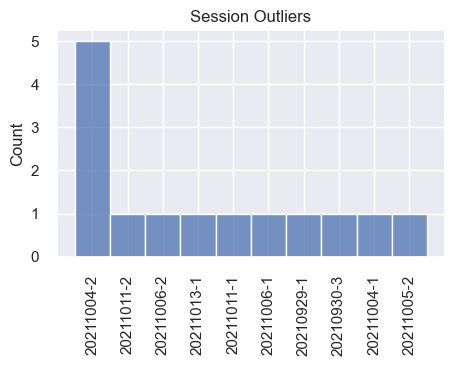

In [96]:
fig, ax = plt.subplots(figsize=[5, 3], dpi=100)

sns.histplot(outlier_ids)
plt.title('Session Outliers')
plt.xticks(rotation=90)
plt.show()

**Comment**

These sessions are worth examining and comparing with other sources. Especially session 20211004-2, as it contains 5 outliers within the same session!

## Rush and off hours

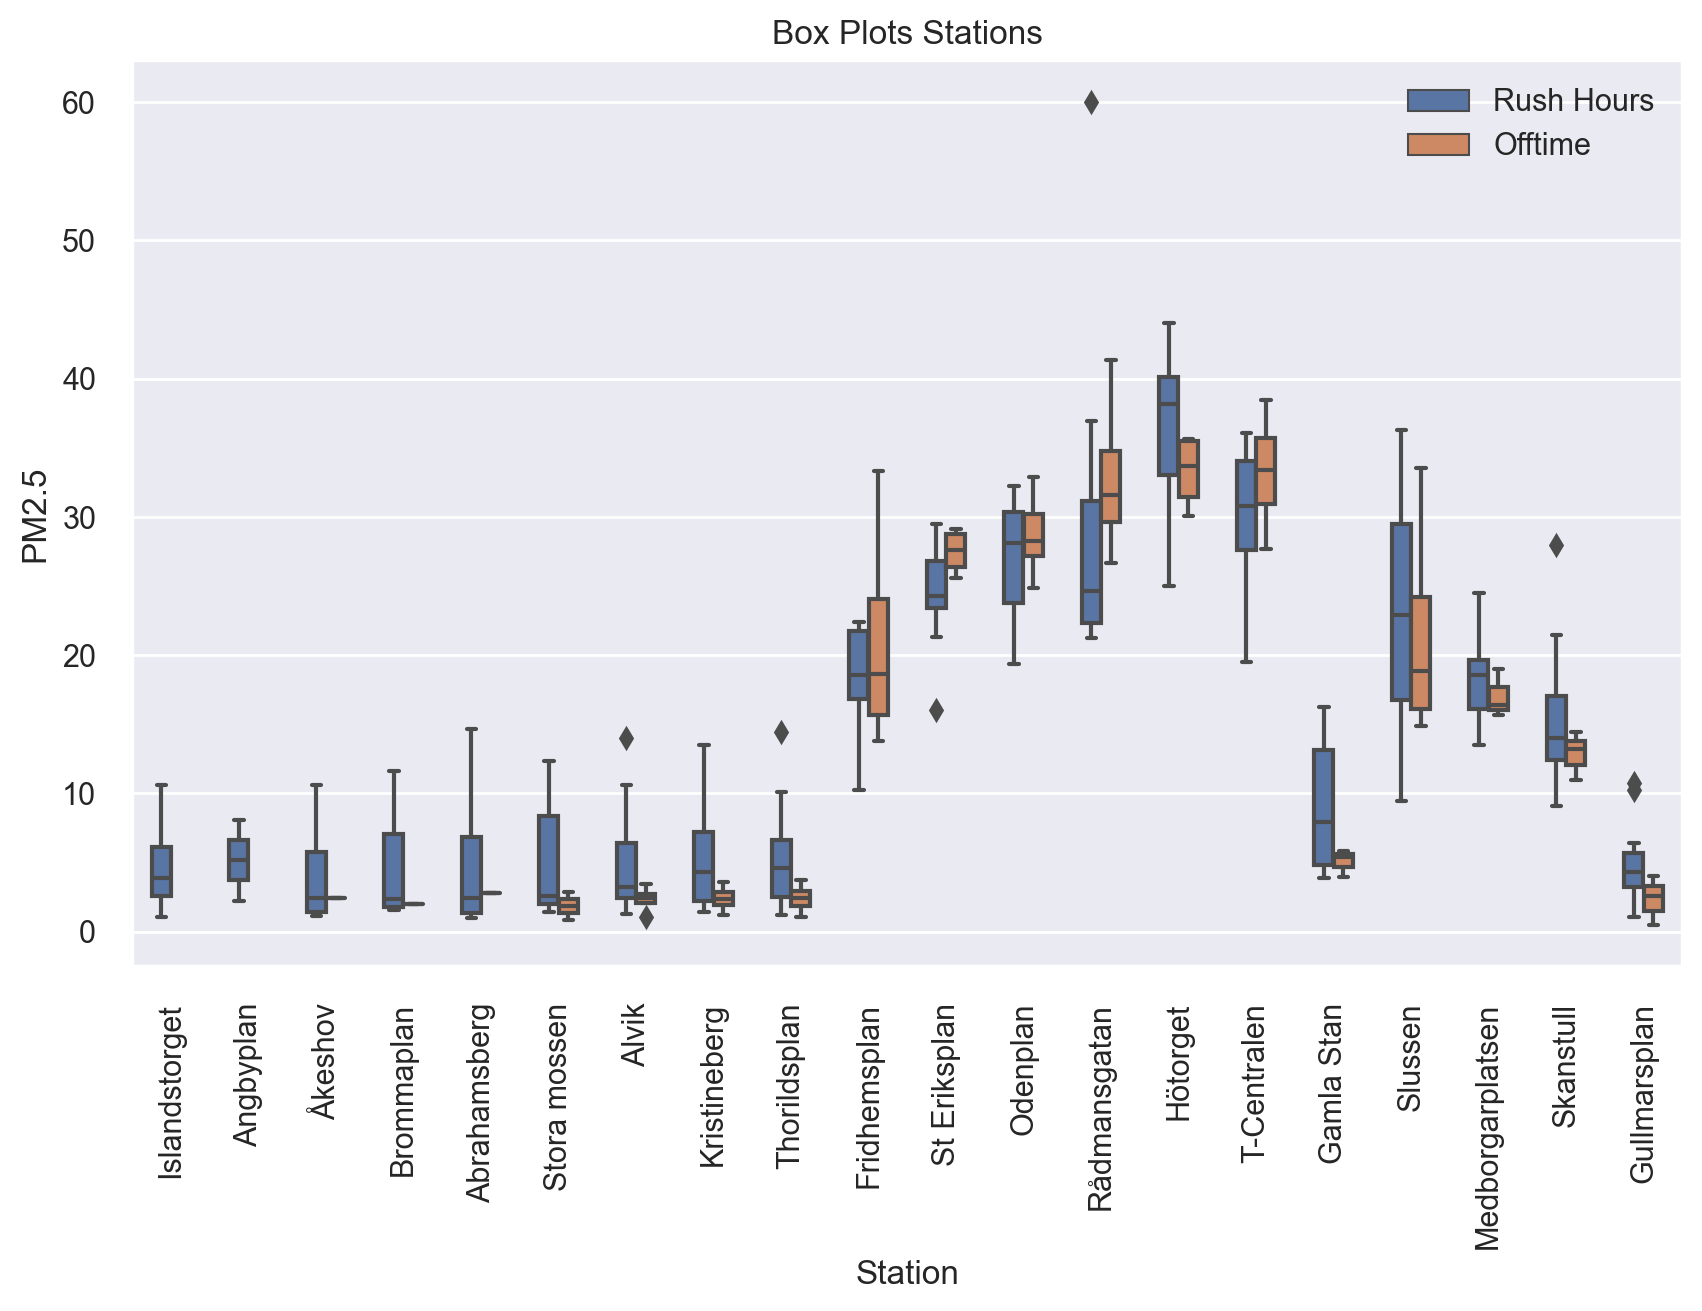

In [330]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

plot_df = s_df.copy()
plot_df['Period'] = plot_df['Period'].apply(lambda x: 'Rush Hours' if x in ['Evening rush', 'Morning rush'] else x)

sns.boxplot(
    x='Station', 
    y=param, 
    data=plot_df, 
    width=0.5, 
    order=get_green_line(), 
    hue='Period'
).set_title('Test')

plt.legend()
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots_rush_vs_offtime({param}).pdf')

plt.show()

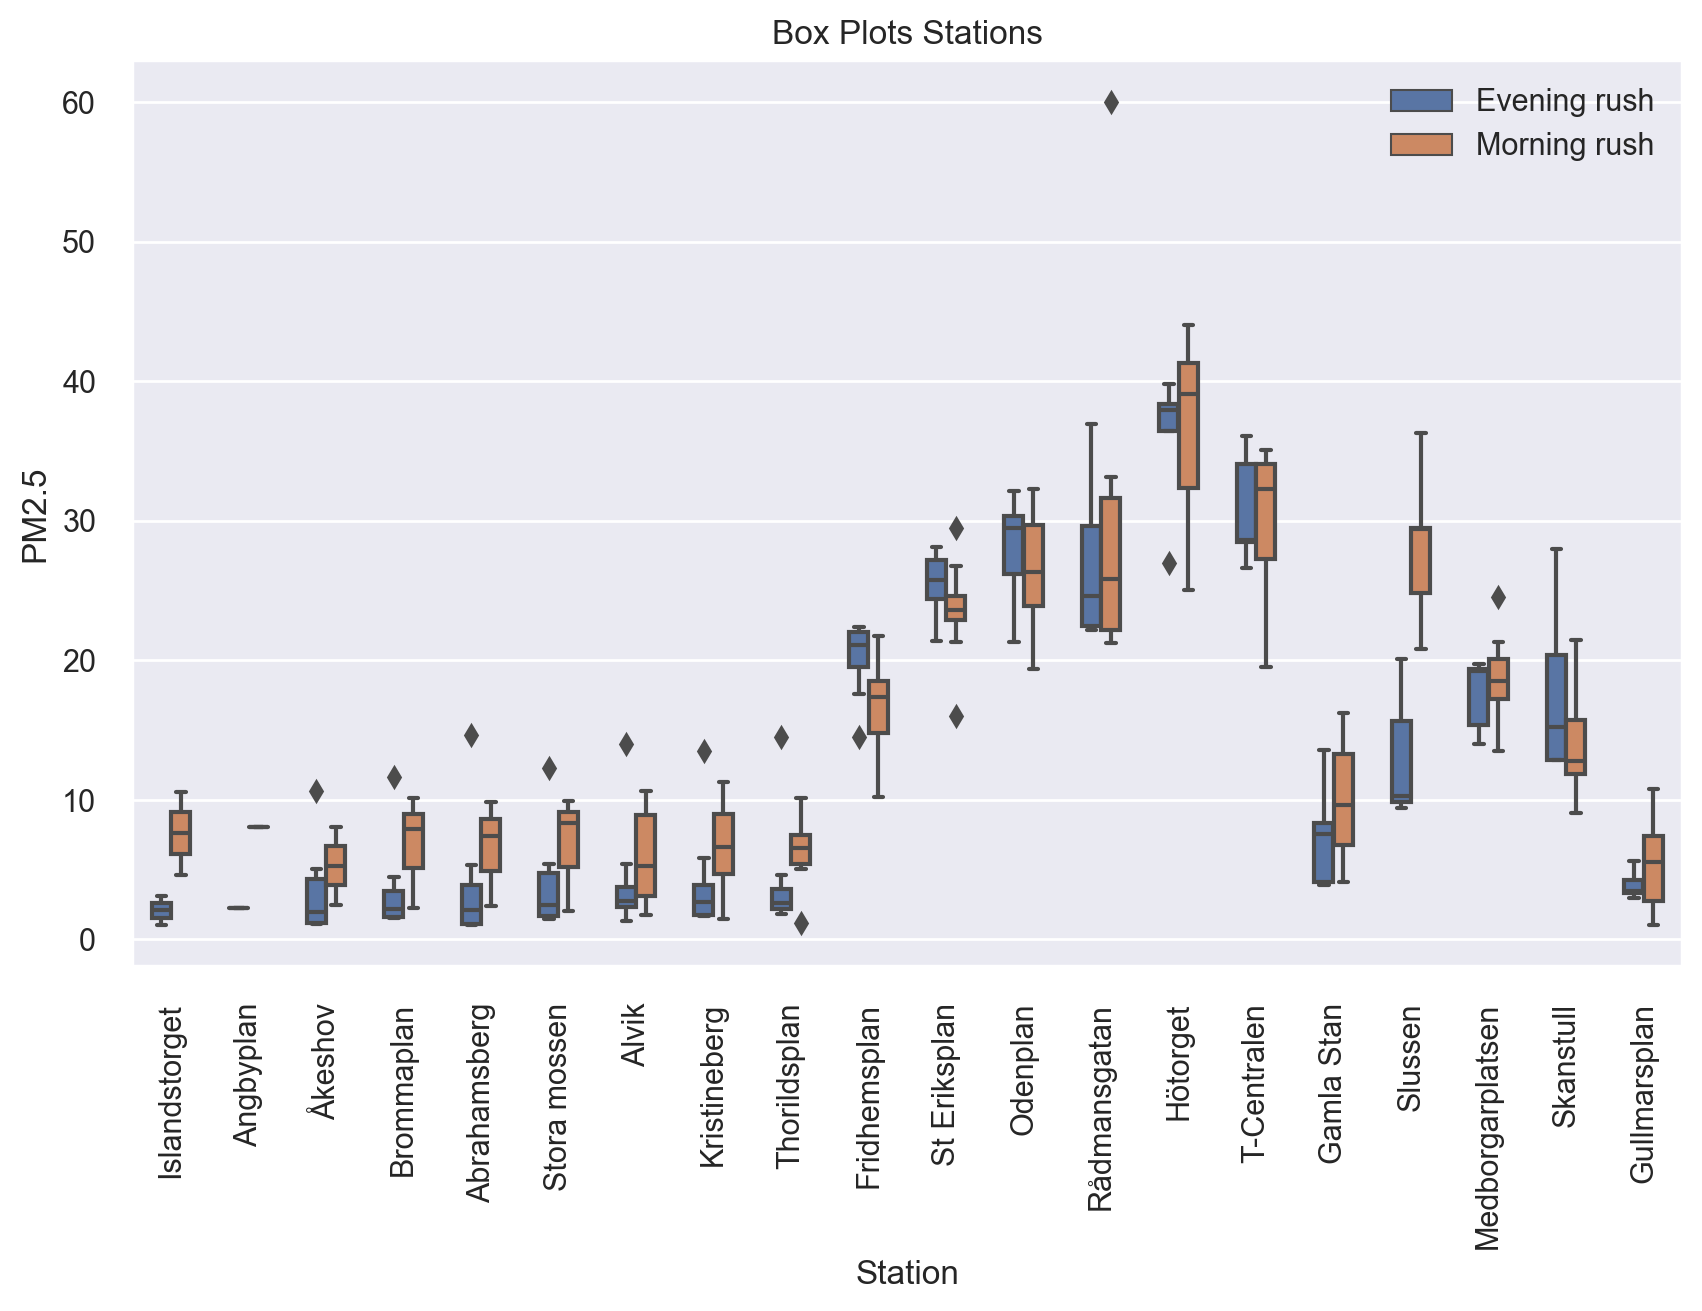

In [329]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

plot_df = s_df.loc[s_df['Period'] != 'Offtime']

sns.boxplot(
    x='Station', 
    y=param, 
    data=plot_df, 
    width=0.5, 
    order=get_green_line(), 
    hue='Period'
).set_title('Test')

plt.legend()
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots_morning_evening_rush({param}).pdf')

plt.show()

### Histograms

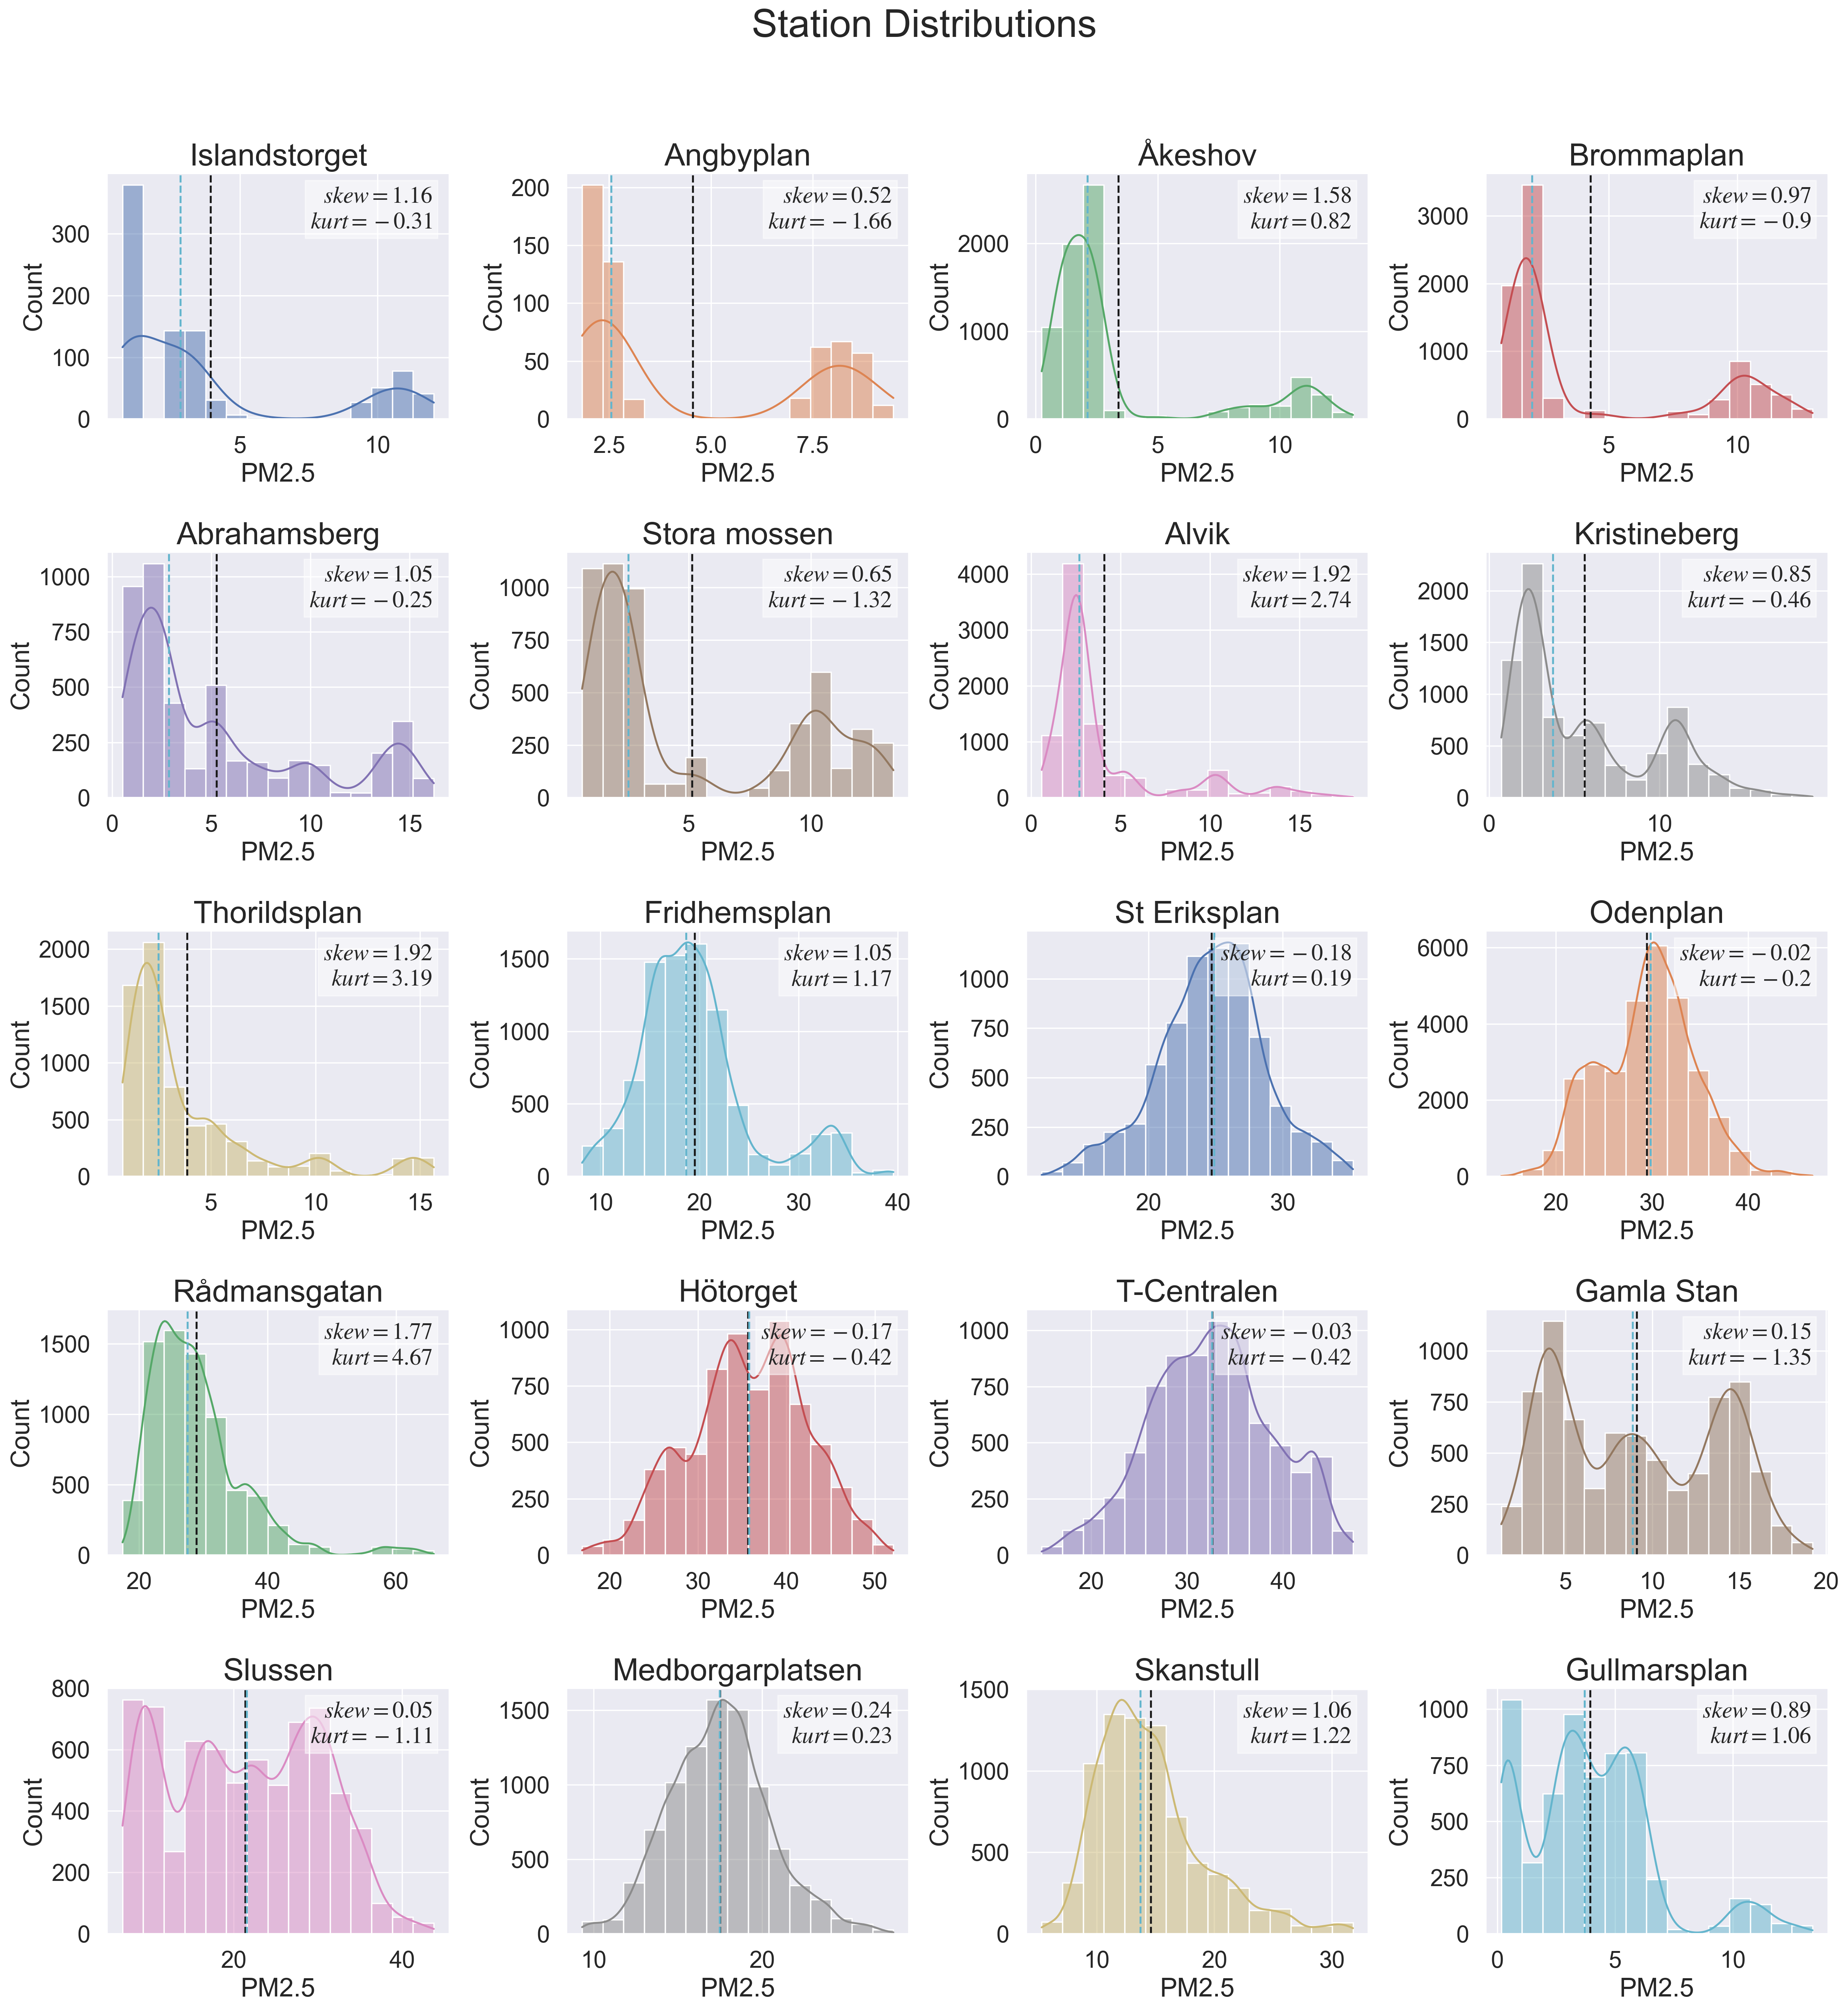

In [157]:
plot_distributions(
    df=r_df, 
    dist_col='Station', 
    title='Station Distributions', 
    fig_name=f'{fig_folder}/distributions({param}).pdf',
    param=param,
    with_textbox=True,
    column_count=4,
    bins=15
)

### Normal distribution

In [337]:
normal = r_df.groupby('Station').agg({param: [skew, kurtosis]})

normal.head(10)

PM2.5          
                   skew  kurtosis
Station                          
Abrahamsberg   1.048203 -0.245440
Alvik          1.923020  2.741124
Angbyplan      0.524323 -1.657415
Brommaplan     0.969021 -0.898802
Fridhemsplan   1.052310  1.170357
Gamla Stan     0.149744 -1.345074
Gullmarsplan   0.891134  1.057893
Hötorget      -0.167546 -0.417548
Islandstorget  1.155322 -0.313787
Kristineberg   0.846879 -0.458000

#### QQ Plots

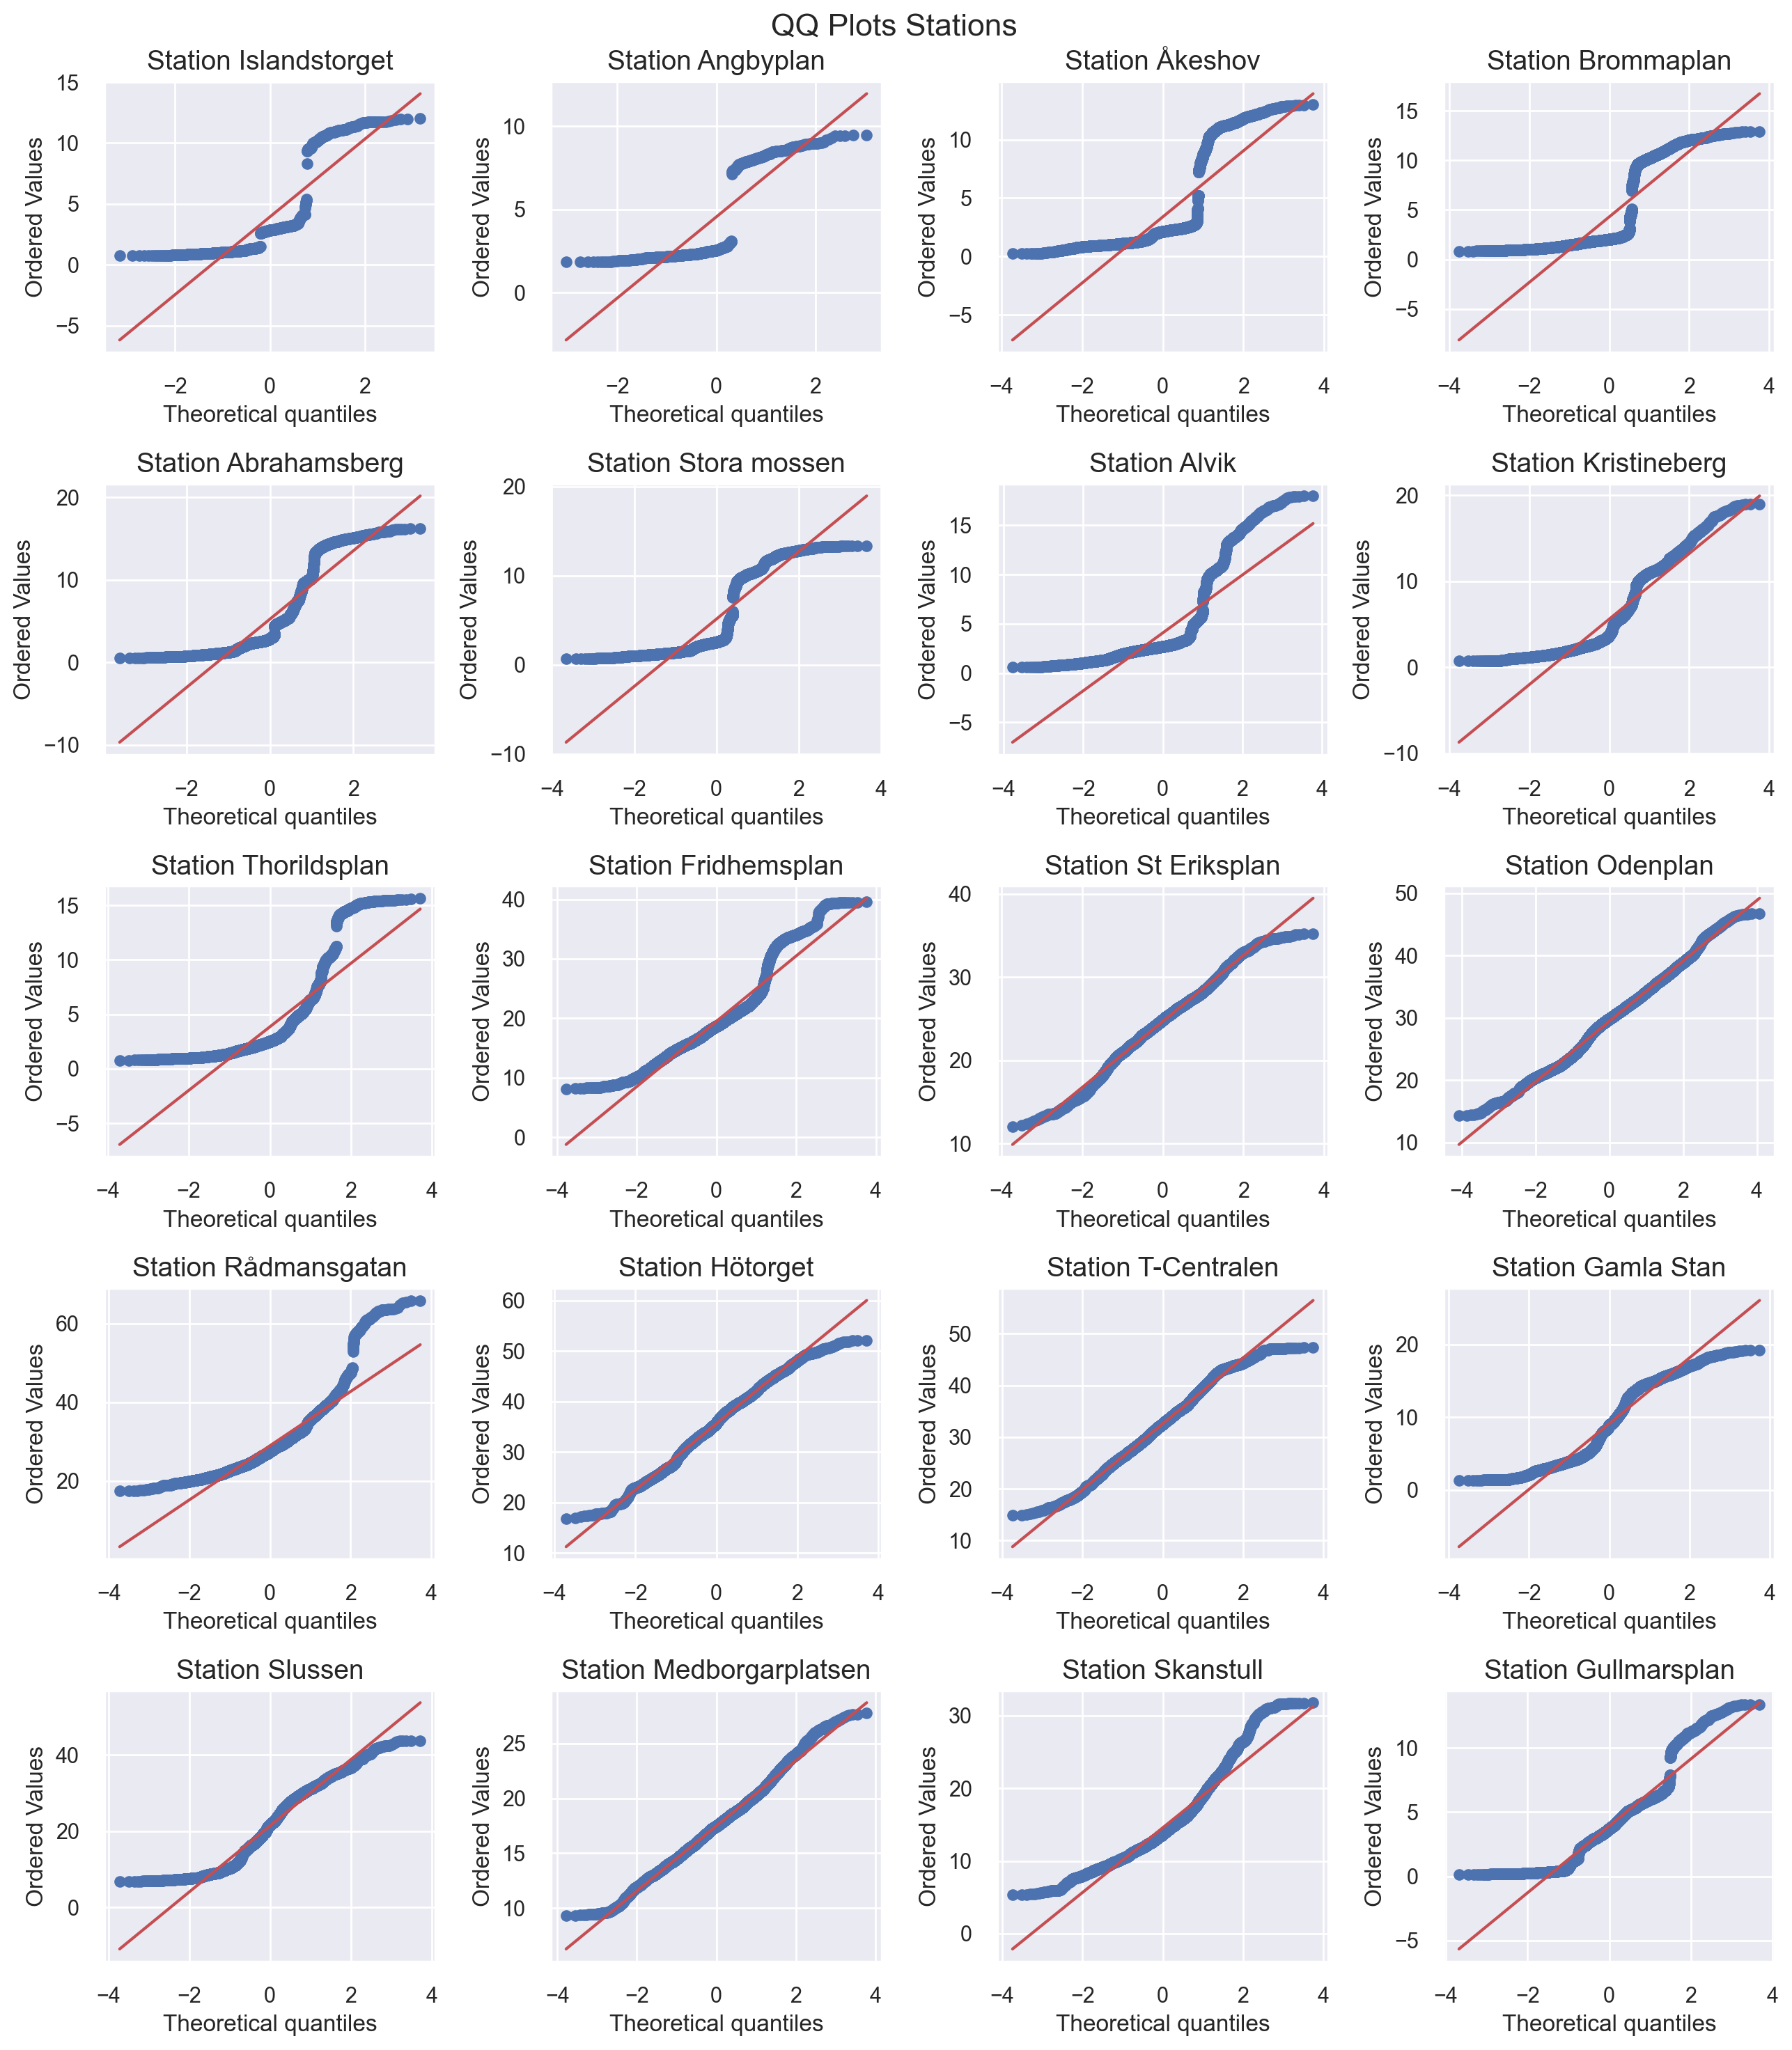

In [338]:
plot_QQ_plots(
    r_df, 
    title='QQ Plots Stations', 
    param=param, 
    fig_name=f'{fig_folder}/QQPlots({param}).pdf',
    col_count=4,
    row_count=5,
    label='Station',
    size=(13, 15)
)

# Focus on Hötorget

In [389]:
focus_s_df = s_df.loc[s_df.Station == 'Hötorget'].sort_values(by=['Timestamp'])
focus_r_df = r_df.loc[r_df.Station == 'Hötorget'].sort_values(by=['Sensor'])

### Box plots sensors

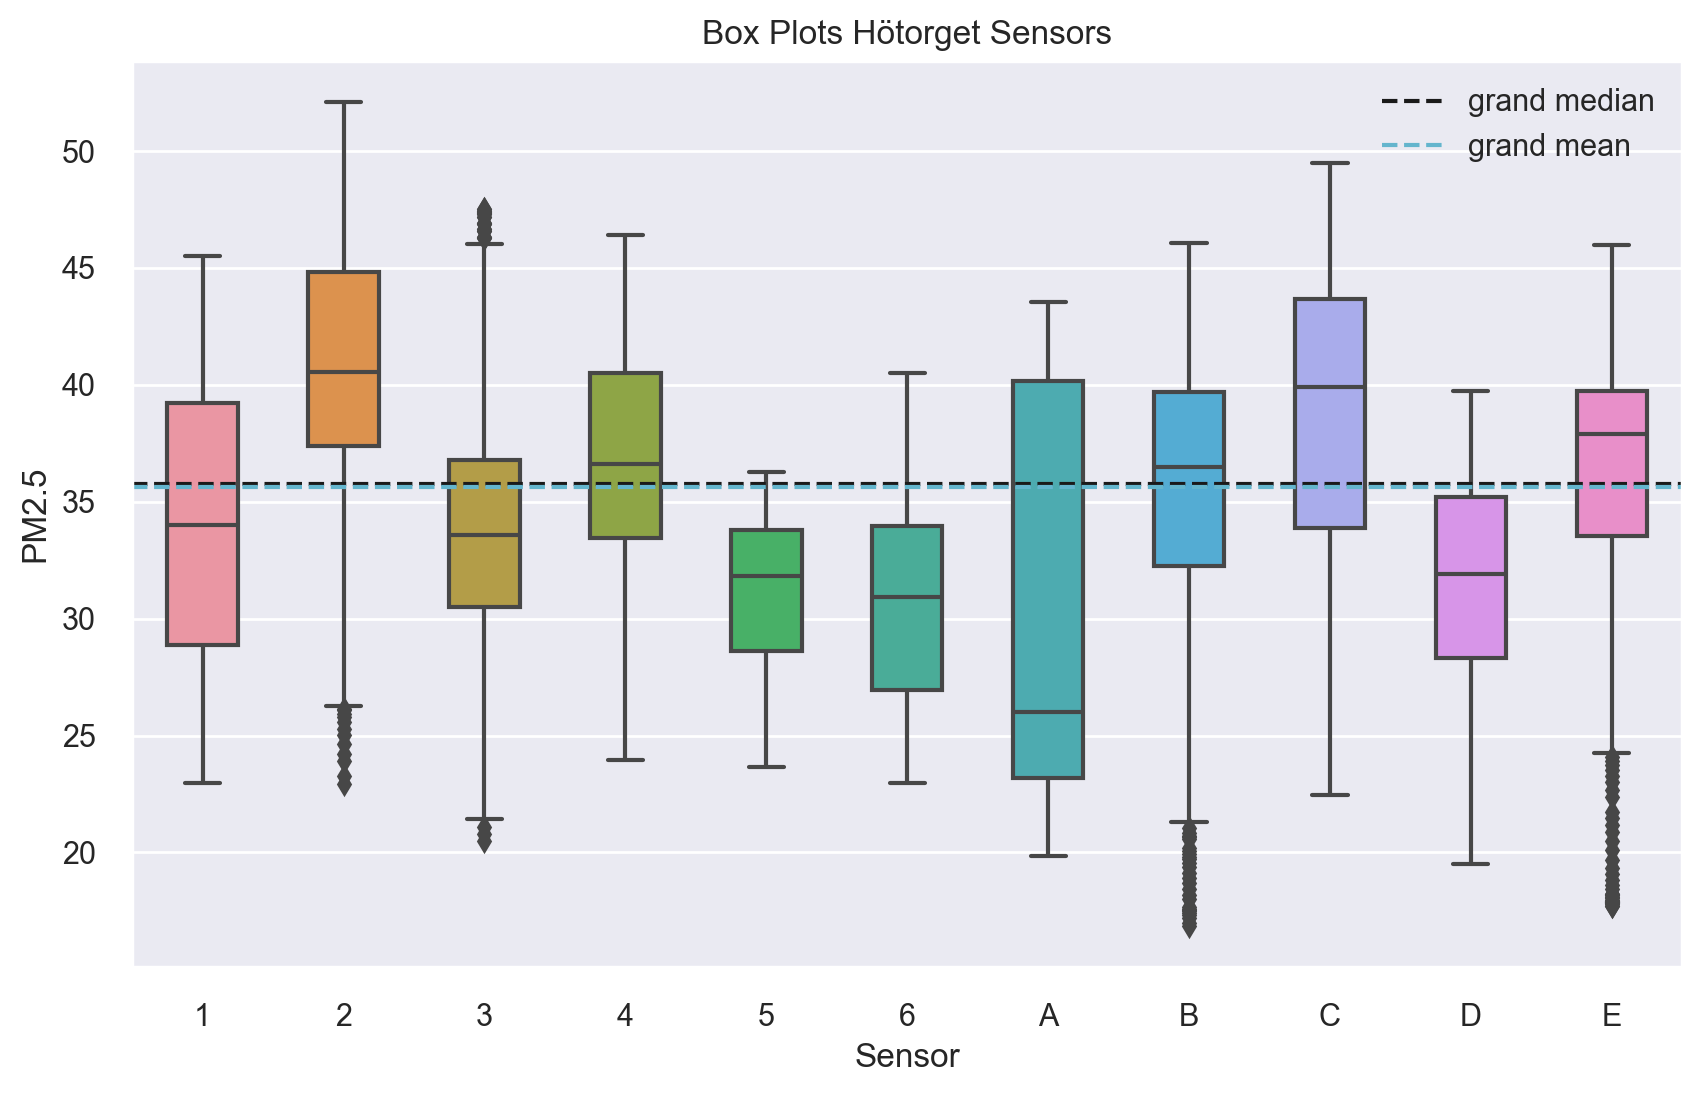

In [379]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Sensor', y=param, data=focus_r_df, width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.legend()
plt.title('Box Plots Hötorget Sensors')
plt.savefig(f'{fig_folder}/Hotorget_box_plot_sensor({param}).pdf')
plt.show()

In [381]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles = focus_r_df.groupby('Sensor').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles

PM2.5                                                           \
             Q1      Q2       Q3      IQR lowerLimit upperLimit outliers   
Sensor                                                                     
1       28.8850  33.990  39.2350  10.3500   13.36000   54.76000      0.0   
2       37.3800  40.530  44.8150   7.4350   26.22750   55.96750     12.0   
3       30.5150  33.590  36.7850   6.2700   21.11000   46.19000     27.0   
4       33.4300  36.600  40.5100   7.0800   22.81000   51.13000      0.0   
5       28.6300  31.840  33.8100   5.1800   20.86000   41.58000      0.0   
6       26.9600  30.930  33.9750   7.0150   16.43750   44.49750      0.0   
A       23.2025  26.010  40.1850  16.9825   -2.27125   65.65875      0.0   
B       32.2700  36.480  39.7000   7.4300   21.12500   50.84500     27.0   
C       33.8975  39.925  43.6825   9.7850   19.22000   58.36000      0.0   
D       28.3350  31.920  35.2050   6.8700   18.03000   45.51000      0.0   
E       33.5375  37.900  39.7425   6.2050   24.23000   49.05000     40.0   

                             
       prcnt_outliers count  
Sensor                       
1            0.000000   506  
2            0.935308  1283  
3            3.233533   835  
4            0.000000   773  
5            0.000000   345  
6            0.000000   271  
A            0.000000   218  
B            2.072141  1303  
C            0.000000   424  
D            0.000000   423  
E            9.345794   428

### Box plot sessions

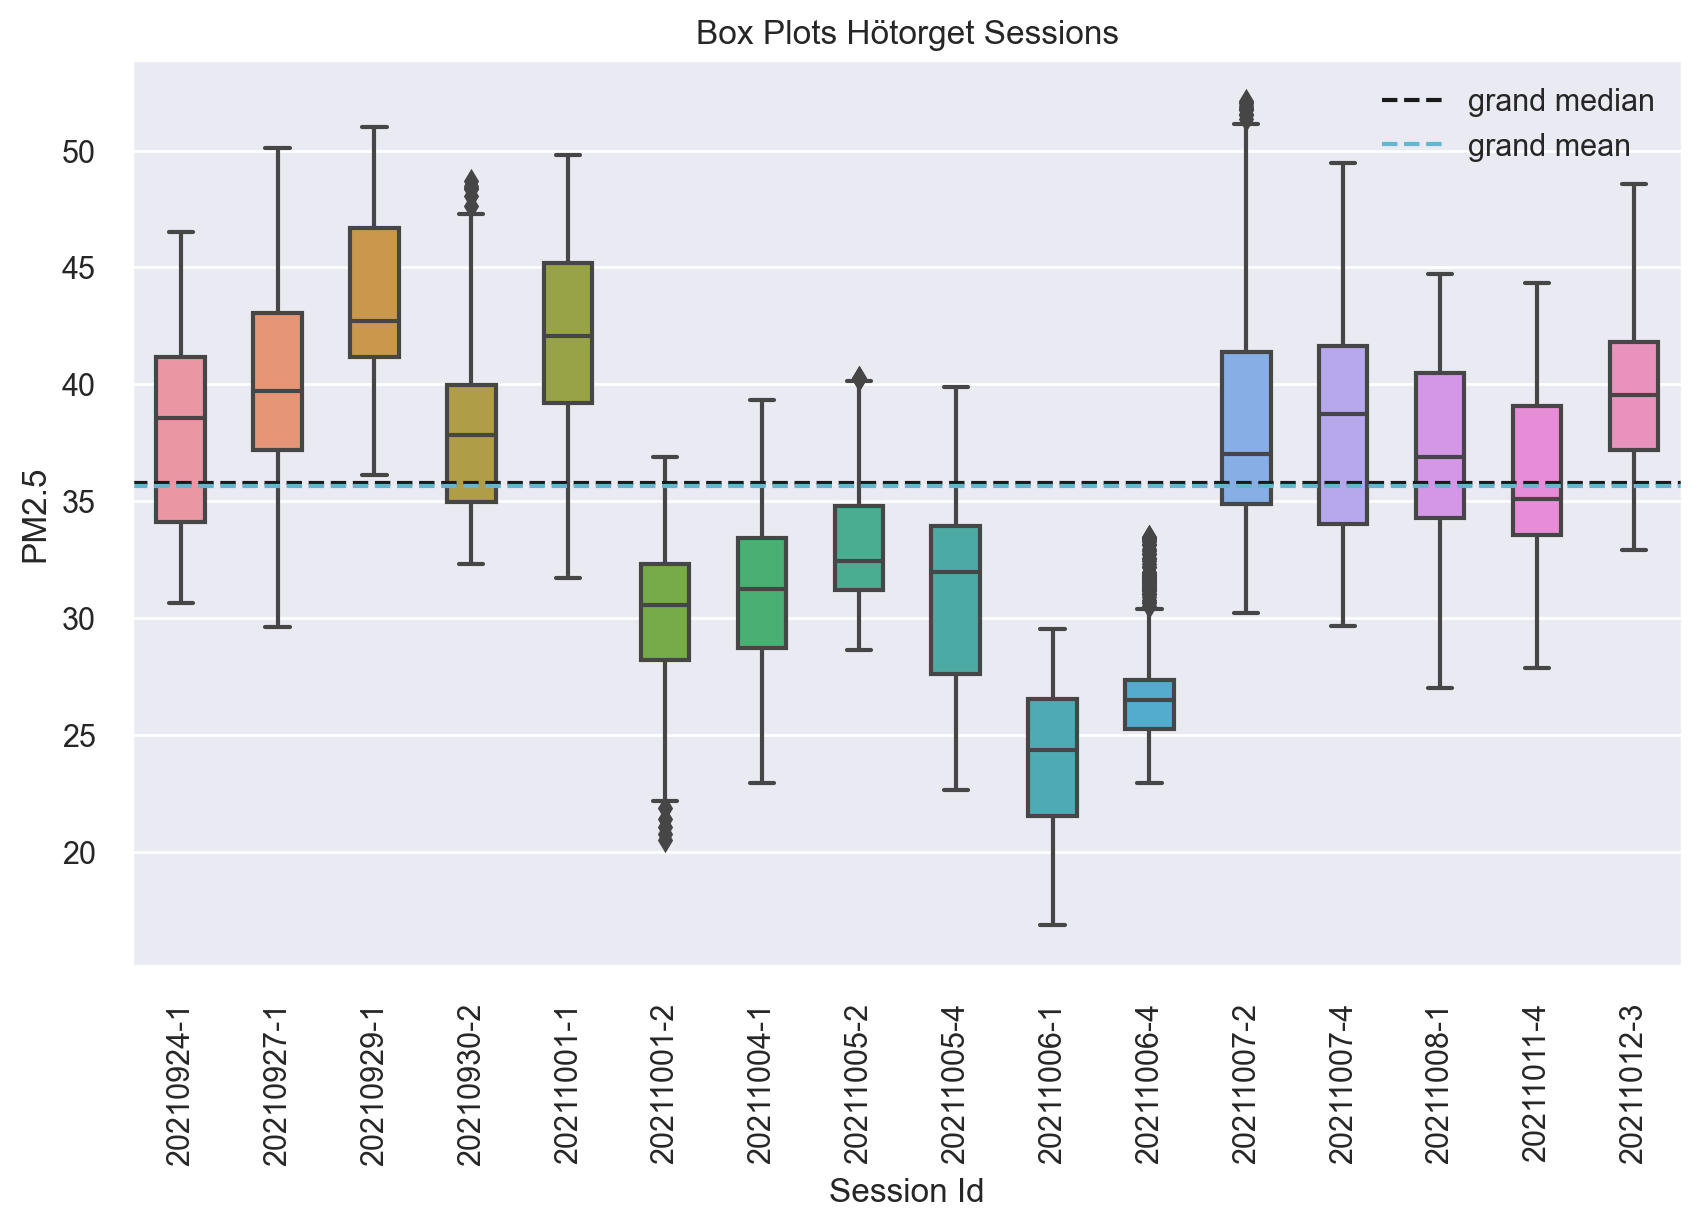

In [394]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Session Id', y=param, data=focus_r_df.sort_values(by=['Timestamp']), width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.xticks(rotation=90)
plt.legend()
plt.title('Box Plots Hötorget Sessions')
plt.savefig(f'{fig_folder}/Hotorget_box_plot_sessions({param}).pdf')
plt.show()

### Distribution

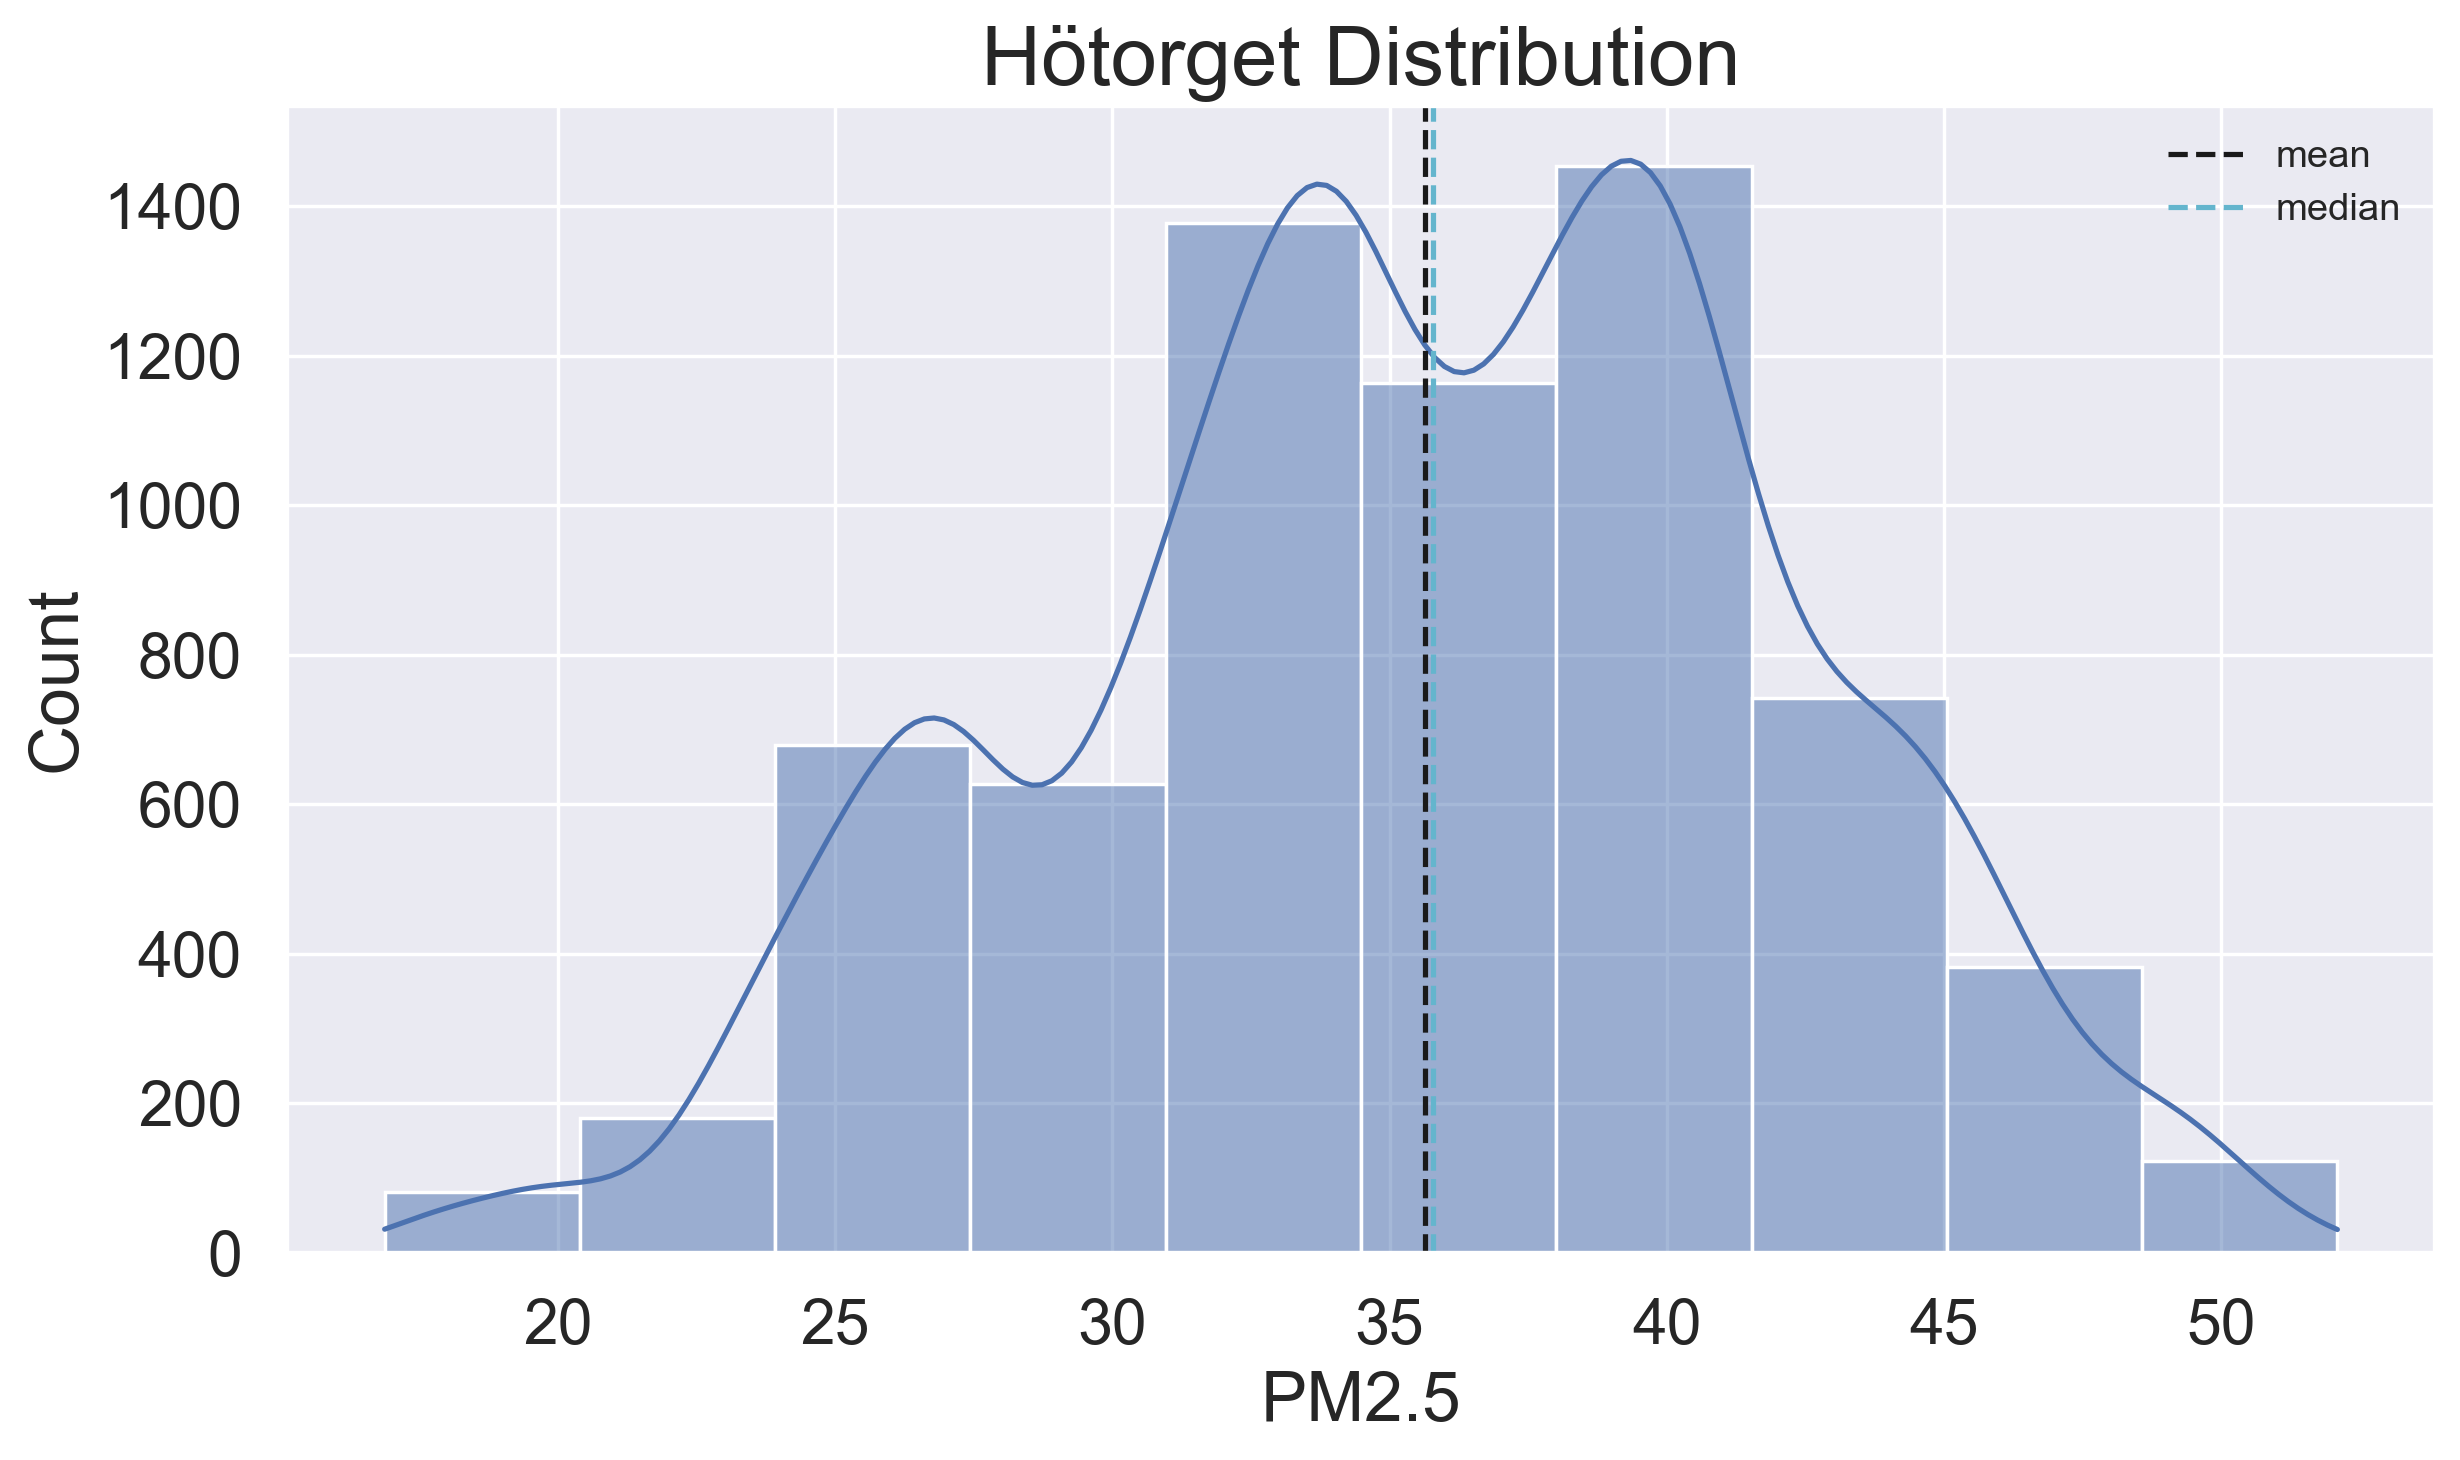

In [366]:
fig, ax = plt.subplots(dpi=250, figsize=[10, 6])

mean = focus_r_df[param].mean()
median = focus_r_df[param].median()
std = focus_r_df[param].std()
s_skew = stats.skew(focus_r_df[param], bias=False)
s_kurt = stats.kurtosis(focus_r_df[param], bias=False)

sns.histplot(focus_r_df, x=param, kde=True, bins=10)

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

ax.set_xlabel(param, fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title(f"Hötorget Distribution", fontsize=24)

ax.axvline(mean, c="k", linestyle="--", label="mean")
ax.axvline(median, c="c", linestyle="--", label="median")
ax.legend()
plt.tight_layout()

plt.savefig(f'{fig_folder}/HotorgetDistribution({param}).pdf')

plt.show()

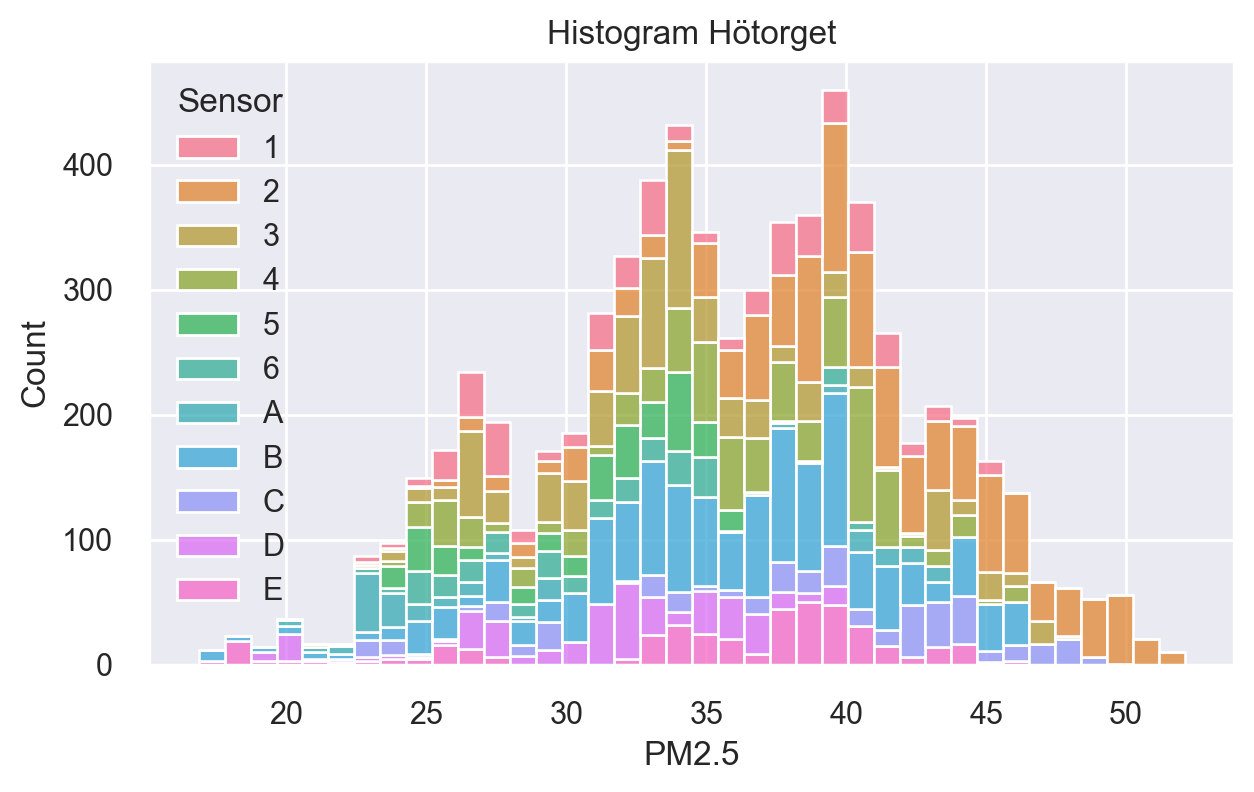

In [374]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', multiple='stack')
plt.title('Histogram Hötorget')

plt.savefig(f'{fig_folder}/HotorgetHistogram1Sensor({param}).pdf')

plt.show()

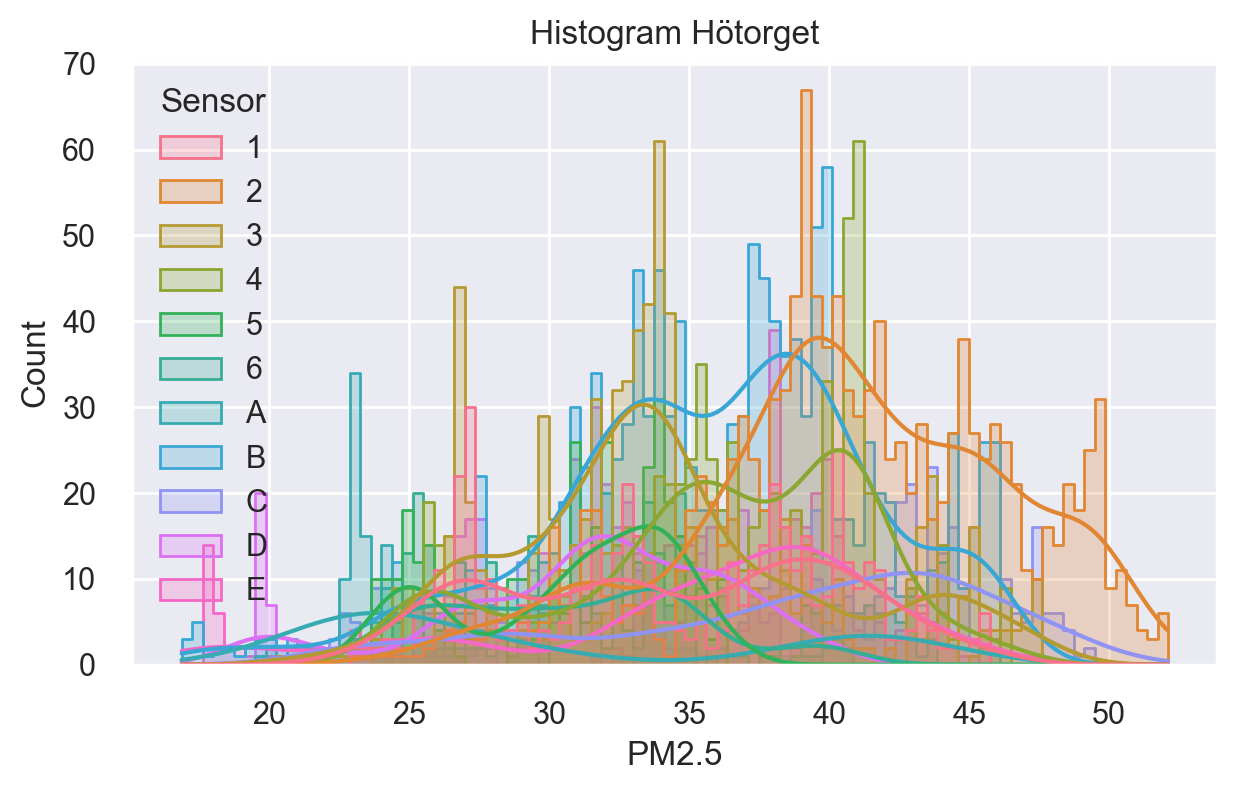

In [373]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', kde=True, element='step', bins=94)
plt.title('Histogram Hötorget')

plt.savefig(f'{fig_folder}/HotorgetHistogram2Sensor({param}).pdf')

plt.show()

## ANOVA

In [348]:
anova_df = perform_ANOVA(
    focus_r_df,
    param=param,
    alpha=0.1,
)

anova_df

0
SST                              295047.814574
SSW                              227733.968812
SSB                               67313.845762
Alpha                                      0.1
F-stat                              200.935998
F-crit                                1.599657
P-value                                    0.0
F-stat > F-crit  True (Significant Difference)
p-value < alpha  True (Significant Difference)

In [350]:
# Anova per session
anovas = []

for session_id in focus_r_df['Session Id'].unique():
    anova_df = perform_ANOVA(
        focus_r_df[focus_r_df['Session Id'] == session_id],
        param=param,
        alpha=0.1,
    )
    
    anovas.append(anova_df)
    
anovas_df = pd.concat(anovas, axis=1)

anovas_df

0                              0  \
SST                               13605.374747                    6196.595076   
SSW                                8712.067149                    2756.428708   
SSB                                4893.307598                    3440.166367   
Alpha                                      0.1                            0.1   
F-stat                              151.276479                     150.182258   
F-crit                                2.090581                       2.099018   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Difference)   

                                             0                              0  \
SST                                  2691.2475                   10585.000613   
SSW                                 634.886053                    3960.215206   
SSB                                2056.361447                    6624.785408   
Alpha                                      0.1                            0.1   
F-stat                              329.724672                     254.828486   
F-crit                                1.858621                        2.09581   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Difference)   

                                             0                              0  \
SST                                4267.090242                     4121.94123   
SSW                                3492.713385                    3051.142098   
SSB                                 774.376857                    1070.799133   
Alpha                                      0.1                            0.1   
F-stat                               22.171211                      27.900546   
F-crit                                1.958965                       1.962619   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Difference)   

                                             0                              0  \
SST                               11530.251131                      2442.1313   
SSW                                4898.220966                      1124.0321   
SSB                                6632.030165                      1318.0992   
Alpha                                      0.1                            0.1   
F-stat                              165.522481                     152.444842   
F-crit                                1.956389                        2.74452   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Difference)   

                                             0                              0  \
SST                                5142.162075                    2960.138243   
SSW                                3635.176491                     820.278864   
SSB                                1506.985584                    2139.859379   
Alpha                                      0.1                            0.1   
F-stat                               79.387546                     227.608852   
F-crit                                2.316484                       1.961035   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Differ

### Tukey

In [349]:
tukey_df = focus_r_df[[param, 'Sensor']]

tukey = pairwise_tukeyhsd(
    endog=tukey_df[param],
    groups=tukey_df['Sensor'],
    alpha=0.1
)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.10 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2   6.2782  0.001   5.3733  7.1832   True
     1      3  -0.2525    0.9  -1.2237  0.7187  False
     1      4   1.7434  0.001   0.7576  2.7292   True
     1      5  -3.5892  0.001  -4.7928 -2.3856   True
     1      6  -3.4936  0.001  -4.7912 -2.1959   True
     1      A  -4.3594  0.001   -5.756 -2.9628   True
     1      B   1.3455  0.001   0.4425  2.2485   True
     1      C   4.1984  0.001   3.0634  5.3334   True
     1      D  -2.8902  0.001  -4.0259 -1.7545   True
     1      E   0.9564 0.2954  -0.1757  2.0885  False
     2      3  -6.5308  0.001  -7.2973 -5.7643   True
     2      4  -4.5349  0.001  -5.3198 -3.7499   True
     2      5  -9.8674  0.001 -10.9129  -8.822   True
     2      6  -9.7718  0.001 -10.9243 -8.6193   True
     2      A -10.6377  0.001 -11.9005 -9.3748   True
     2      B  -4.9328  0.00

## Distributions